In [ ]:
import os, sys, math
import simpy
import numpy as np
import random
from matplotlib import pyplot as plt
import logging
import pickle


from Client import ClientClock
from Battery import Battery
from App import Application
from Temperature import *
from Oscillator import Oscillator
from Radio import SyncRadio
import helpers
import time_simulator

logger = logging.getLogger('time_sim.notebook')

In [ ]:
#Setup 

osc_low_f_xtal = Oscillator(80-6, 32768, 1.5e-6, temperature_vs_drift_model='quadratic') #quadratic model; tuning fork
osc_low_f_xtal_ctrl = Oscillator(80e-6, 32768, 1.5e-6, temperature_vs_drift_model='quadratic', allow_random=False)
osc_med_f_xtal = Oscillator(20e-6, 12e6, 300e-6, temperature_vs_drift_model='cubic') #cubic model; assume AT cut 35˚15' centered around 20 C
osc_high_f_xtal = Oscillator(20e-6, 40e6, 2.5e-3, temperature_vs_drift_model='cubic') #cubic temperature model; also AT cut

dist_from_gateway = 1000
t_prop = dist_from_gateway / 3e8
lora_radio = SyncRadio(80e-3, 5e-3, 1e3, 1e3, 500e3, 600e-9, 1, propagation_time=t_prop) #1 second delay for the sake of LoRaWAN, but not required...

test_application = Application(60, 1e-3, inter_window_period=3600)

app = test_application
battery = Battery(1000, stop_early_capacity=950)

In [ ]:
## The whole shebang. This is a lot of data, and requires a lot of time to run properly
order_of_rate_adjust = 0
time_simulator.set_logger_levels(logging.WARNING)
# sync_tol_arr = np.logspace(-6,0, num=19)
# window_size_arr = np.logspace(-1, 3, num=13)
sync_tol_arr = np.logspace(-6,0, num=3)
window_size_arr = np.logspace(-1, 3, num=3)
window_size_arr = np.append(window_size_arr, math.inf)
# sync_tol_arr = np.asarray([1e-3])
battery_life_expected = np.zeros((sync_tol_arr.shape[0], window_size_arr.shape[0]))
energy_per_window_arr = np.zeros((sync_tol_arr.shape[0], window_size_arr.shape[0]))

osc = osc_med_f_xtal

for i, sync_tol in enumerate(sync_tol_arr):
    for j, w in enumerate(window_size_arr):
        inter_window_period = max(100, 2*w)
        app = Application(w, sync_tol, inter_window_period = inter_window_period)
        battery.recharge() 

        env = simpy.Environment()
        # sim_process = env.process(run_sim(env, app, osc_high_f_xtal, lora_radio, battery, plot_n_windows=0, max_windows=50, steps_per_second=100, order_of_rate_adjust=0))
        sim_process = env.process(time_simulator.run_sim(env, app, osc, lora_radio, battery, plot_n_windows=0, max_windows=math.inf, steps_per_second=500, order_of_rate_adjust=order_of_rate_adjust))
        try:
            print(f'Run sim for: Sync tol= {sync_tol} \tand window size= {w}')
            env.run(until=sim_process)
            # x, y, z = yield sim_process
            logger.info('\n\nSimulation exited')
        except (EnvironmentError) as e: #used for telling that the battery has died or exit for some other valid reason
            logger.error(e)
            logger.warning(f'Sync tol was {sync_tol} and window size was {w}')

        except BaseException as e:
            logger.error(e)
            logger.warning(f'Sync tol was {sync_tol} and window size was {w}')
            raise e

        extrapolated_lifetime, average_energy_per_window = helpers.extrapolate_battery_life(battery, test_application, env.now, only_include_useful_life=True)
        battery_life_expected[i][j] = extrapolated_lifetime
        energy_per_window_arr[i][j] = average_energy_per_window
        logger.info(f"Results for sync tolerance {sync_tol}")
        logger.info(f"Estimated battery lifetime: {extrapolated_lifetime} days")
        logger.info(f"Energy per window: {average_energy_per_window} mAh\n")

outdata = {'sync_tol':sync_tol_arr, 'window_size':window_size_arr, 'battery_life':extrapolated_lifetime}
outfile = open(f'./data_store/heatmap_input_data_small_RA={order_of_rate_adjust}.pickle', 'wb')
pickle.dump(outdata, outfile)
outfile.close()



In [1]:
# Generate battery plots
sync_tol_arr = np.logspace(-4,-1, num=20)
w = 100
import helpers
# sync_tol_arr = np.asarray([1e-3])
battery_life_expected = np.zeros((sync_tol_arr.shape[0]))
energy_per_window_arr = np.zeros((sync_tol_arr.shape[0]))

test_application = Application(60, 1e-3, inter_window_period=100000)

app = test_application

for i, sync_tol in enumerate(sync_tol_arr):
    battery.recharge() 
    app.restart_application(new_sync_tolerance=sync_tol, new_window_size=w)

    env = simpy.Environment()
    # sim_process = env.process(run_sim(env, app, osc_high_f_xtal, lora_radio, battery, plot_n_windows=0, max_windows=50, steps_per_second=100, order_of_rate_adjust=0))
    sim_process = env.process(time_simulator.run_sim(env, app, osc_low_f_xtal, lora_radio, battery, plot_n_windows=0, max_windows=20, steps_per_second=64, order_of_rate_adjust=0))
    try:
        logger.info(f'Run sim for: Sync tol= {sync_tol} \tand window size= {w}')
        env.run()
        # x, y, z = yield sim_process
        logger.info('\n\nSimulation exited')
    except (EnvironmentError) as e: #used for telling that the battery has died or exit for some other valid reason
        logger.error(e)
        logger.warning(f'Sync tol was {sync_tol} and window size was {w}')

    except BaseException as e:
        logger.error(e)
        logger.warning(f'Sync tol was {sync_tol} and window size was {w}')
        raise e

    extrapolated_lifetime, average_energy_per_window = helpers.extrapolate_battery_life(battery, test_application)
    battery_life_expected[i] = extrapolated_lifetime
    energy_per_window_arr[i] = average_energy_per_window
    logger.info(f"Results for sync tolerance {sync_tol}")
    logger.info(f"Estimated battery lifetime: {extrapolated_lifetime} days")
    logger.info(f"Energy per window: {average_energy_per_window} mAh\n")

helpers.plot_battery_usage_curve_vs_tol(sync_tol_arr, battery_life_expected, energy_per_window_arr, battery)

    # fig, ax1 = plt.subplots()
    # ax1.loglog(sync_tol_arr, battery_life_expected[i,:], 'r-')
    # ax1.set_xlabel('Synchronization Tolerance (s)')
    # ax1.set_ylabel(f'Battery Life of {battery.starting_capacity}mAh (days)')
    # ax2 = ax1.twinx()
    # ax2.set_ylabel('Battery consumption per Window (mAh)') #yes, I know that mAh is units of charge and not actual energy. Let's not be overly pedantic
    # ax2.loglog(sync_tol_arr, energy_per_window_arr[i,:], 'b-')
    # plt.title('Battery Life Plot')
    # plt.subplots_adjust(right=0.8)

    # plt.show()



NameError: name 'np' is not defined

# Temperature compensation testing

In [ ]:
#Setup 
osc_low_f_xtal = Oscillator(20e-6, 32768, 1.5e-6, temperature_vs_drift_model='quadratic') #quadratic model; tuning fork
osc_med_f_xtal = Oscillator(20e-6, 12e6, 870e-6, temperature_vs_drift_model='cubic') #cubic model
osc_high_f_xtal = Oscillator(20e-6, 40e6, 2.5e-3, temperature_vs_drift_model='cubic') #cubic temperature model

osc_low_f_xtal_ctrl = Oscillator(20e-6, 32768, 1.5e-6, temperature_vs_drift_model=None)

dist_from_gateway = 10
t_prop = dist_from_gateway / 3e8
lora_radio = SyncRadio(80e-3, 5e-3, 1e3, 1e3, 500e3, 600e-9, 1, propagation_time=t_prop) #1 second delay for the sake of LoRaWAN, but not required...

test_application = Application(500, 1e-3, inter_window_period=1000)

app = test_application
battery = Battery.Battery(1000)
osc = osc_low_f_xtal_ctrl

env = simpy.Environment()
# sim_process = env.process(run_sim(env, app, osc_high_f_xtal, lora_radio, battery, plot_n_windows=0, max_windows=50, steps_per_second=100, order_of_rate_adjust=0))
sim_process = env.process(time_simulator.run_sim(env, app, osc, lora_radio, battery, plot_n_windows=5, max_windows=20, steps_per_second=64, order_of_rate_adjust=0))
try:
    env.run()
    # x, y, z = yield sim_process
    logger.info('\n\nSimulation exited')
except (EnvironmentError) as e: #used for telling that the battery has died or exit for some other valid reason
    logger.error(e)

except BaseException as e:
    logger.error(e)
    raise e

extrapolated_lifetime, average_energy_per_window = helpers.extrapolate_battery_life(battery, test_application)
battery_life_expected[i] = extrapolated_lifetime
energy_per_window_arr[i] = average_energy_per_window
logger.info(f"Results for sync tolerance {sync_tol}")
logger.info(f"Estimated battery lifetime: {extrapolated_lifetime} days")
logger.info(f"Energy per window: {average_energy_per_window} mAh\n")

In [ ]:
cycle = Temperature.TemperatureCycle.diurnalRoadSurface()
osc = Oscillator(20e-6, 32768, 1.5e-6, temperature_vs_drift_model='quadratic') #quadratic model; tuning fork


t = np.linspace(0, 24*3600, num=200)
ppm, temp = np.zeros(t.shape), np.zeros(t.shape)
sensor = TemperatureSensor(cycle)
for i, tt in enumerate(t):
    temp[i] = (sensor.read(tt)-32) * 5/9
    ppm[i] = osc.temperature_model(temp[i])
# plt.plot(temp, ppm)

temp = np.linspace(-60, 100, num=200)
ppm = np.zeros(temp.shape)

for i, ttemp in enumerate(temp):
    ppm[i] = osc.temperature_model(ttemp)

print(osc.temperature_model.temperature_curve)
print(osc.temperature_model.temperature_curve(25))
print(osc.temperature_model.temperature_curve(0))
print(osc.temperature_model.coefficients)
# plt.figure()
# plt.plot(temp, ppm)

Poly = np.polynomial.polynomial.Polynomial
pp = Poly(np.asarray([-2.5e-05,  2.0e-06 ,-4.0e-08]), domain=[-60,100], window=[-60,100])
pp(25)


In [ ]:
import Temperature, Oscillator
from matplotlib import pyplot as plt
import numpy as np
cycle = Temperature.TemperatureCycle.diurnalRoadSurface()
osc = Oscillator.Oscillator(20e-6, 12e6, 300e-6, temperature_vs_drift_model='cubic') #cubic model; assume AT cut 35˚15' centered around 20 C


t = np.linspace(0, 24*3600, num=24*100)
ppm, temp = np.zeros(t.shape), np.zeros(t.shape)
sensor = Temperature.TemperatureSensor(cycle)
for i, tt in enumerate(t):
    temp[i] = sensor.read(tt)
    ppm[i] = osc.temperature_model(temp[i])


# fig, ax = plt.subplots()
# ax_temp = ax.twinx()


# ax.plot(t/3600, ppm, 'b', label='Frequency Error')
# ax_temp.plot(t/3600, temp, 'r', label='Temperature')

# ax.set_xlabel('Time (hours)')
# ax.set_xlim(0, 24)
# ax.set_ylabel('Frequency Error ∆f/f (parts per million)')
# ax_temp.set_ylabel('Temperature (˚C)')
# ax.legend(loc='lower right')
# ax_temp.legend(loc=0)
# plt.title("Oscillator Frequency Error vs. Temperature Over a Day", pad=15)

# temp = np.linspace(-60, 100, num=200)
# ppm = np.zeros(temp.shape)

# for i, ttemp in enumerate(temp):
#     ppm[i] = osc.temperature_model(ttemp)

# plt.figure()
# plt.plot(temp, ppm)


# heatmap testing


INFO - [time_sim]:  Using application with warm start; we will wake up extra early to synchronize the clock
INFO - [time_sim]:  Using application with warm start; we will wake up extra early to synchronize the clock
INFO - [time_sim]:  Using application with warm start; we will wake up extra early to synchronize the clock
INFO - [time_sim]:  Using application with warm start; we will wake up extra early to synchronize the clock
INFO - [time_sim]:  Using application with warm start; we will wake up extra early to synchronize the clock
/Users/work-reese/code/quals/cost_of_time/helpers.py:235: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im, label=colorbar_label, format=formatter, orientation='vertical', fraction = .5, pad=.1)
[[  0.20972835   0.44549567   0.90927673   2.0520

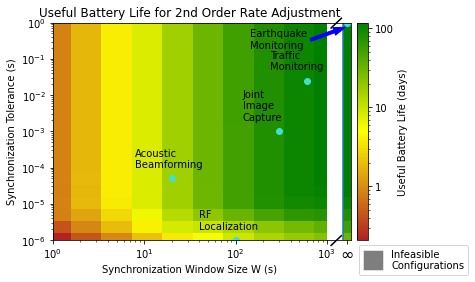

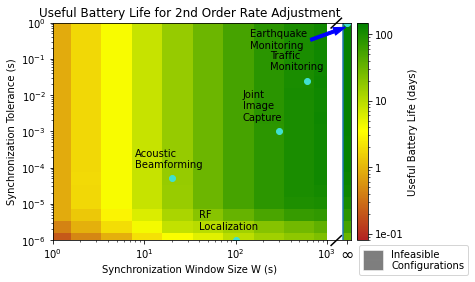

1998.7490386681282


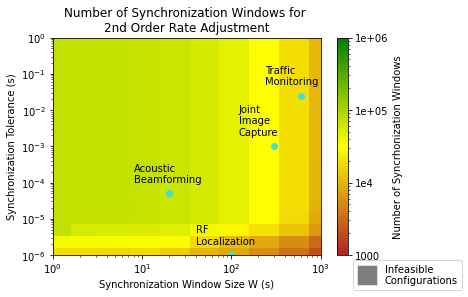

In [39]:
import pickle , math
import numpy as np
import time_simulator, App
import helpers

np.set_printoptions(linewidth=400)

app_earfquake = App.Application(math.inf, 1, name='Earthquake Monitoring')
app_traffic = App.Application(60*10, 25e-3, name='Traffic Monitoring') ## remove for plots in review paper.
app_cameras = App.Application(60*5, 1e-3, name='Joint Image Capture')
app_acoustic = App.Application(20, 50e-6, name='Acoustic Beamforming')
app_localization = App.Application(100, 1e-6, name='RF Localization')
apps = [app_earfquake, app_traffic, app_cameras, app_acoustic, app_localization]

rate_adjustment_order=2
filename = f'./data_store/datamap_fixedTemperature_RA={rate_adjustment_order}.pickle'
with open(filename, 'rb') as infile:
    data = pickle.load(infile)

    bl  = data['battery_life']
    print(bl)
    dubs  = data['window_size']

    # bl[:,:-1] = bl[:,:-1]*86400 / dubs[:-1]
    # bl[:,-1] = 1
    ## outdata = {'sync_tol':sync_tol_arr, 'window_size':window_size_arr, 'battery_life':battery_life_expected, 'energy_per_window':energy_per_window_arr}
    helpers.colormap_battery_power(data['window_size'], data['sync_tol'], data['battery_life'], application_points=apps, rate_adjustment=rate_adjustment_order, normalization_params=None)
    helpers.colormap_battery_power(data['window_size'], data['sync_tol'], data['battery_life'], application_points=apps, rate_adjustment=rate_adjustment_order, normalization_params=[8e-2, 150])
    helpers.colormap_battery_power(data['window_size'], data['sync_tol'], bl, application_points=apps, rate_adjustment=rate_adjustment_order, normalization_params=[1000, 1e6], as_num_windows=True)



[0.83970658 1.79653418 3.84771801 2.77680349 3.57351502 3.83149553 3.93381504 3.98780613 3.93700152 3.85562182 4.05779708]
[[  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.84244311   1.81498865   1.30288084   1.68138016   1.81142298   1.86185405   1.85133979   1.82809689   1.79022417   1.54275308   1.87516173]
 

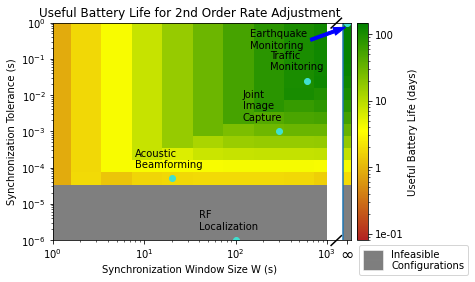

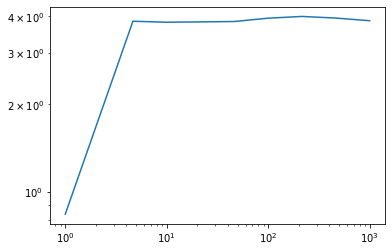

In [54]:
##doctor some data to remove an outlier; Do not run again, except on copy of backup!
from matplotlib import pyplot as plt
import numpy as np
import pickle
filename = './data_store/datamap_fixedTemperature_RA=0.pickle'
data = None
with open(filename, 'rb') as infile:
    data = pickle.load(infile)

    bl = data['battery_life']


    helpers.colormap_battery_power(data['window_size'], data['sync_tol'], bl, application_points=apps, rate_adjustment=rate_adjustment_order, normalization_params=[8e-2, 150])

    # plt.loglog(data['sync_tol'], bl[:,-1])
    # plt.loglog(data['window_size'], bl[6,:])

    data['battery_life'] = bl

# with open(filename, 'wb') as outfile:
#     pickle.dump(data, outfile)

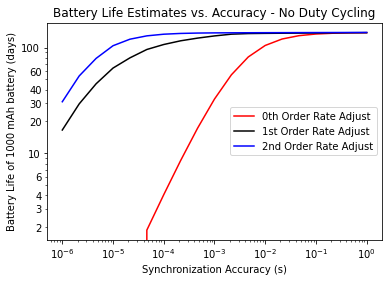

In [3]:
import pickle, helpers
rate_adjusts = [0,1,2]
bl = []
sync_tol = None
window_size_ind = -1
window_size = None

for ra in rate_adjusts:
    filename = f'./data_store/datamap_fixedTemperature_RA={ra}.pickle'
    data = None
    with open(filename, 'rb') as infile:
        data = pickle.load(infile)
        bl.append(data['battery_life'][:,window_size_ind])

        sync_tol = data['sync_tol']
        window_size = data['window_size'][window_size_ind]

# print(bl_100)
helpers.plot_battery_usage_curves(sync_tol, bl, window_size=window_size)

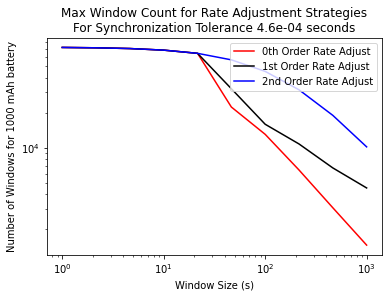

In [22]:
import pickle, helpers
rate_adjusts = [0,1,2]
num_windows = []
sync_tol_ind = 8
sync_tol = None
# window_size_ind = 3
window_sizes = None

for ra in rate_adjusts:
    filename = f'./data_store/datamap_fixedTemperature_RA={ra}.pickle'
    data = None
    with open(filename, 'rb') as infile:
        data = pickle.load(infile)

        sync_tol = data['sync_tol'][sync_tol_ind]
        window_sizes = data['window_size'][:-1]

        bl = data['battery_life'][sync_tol_ind,:-1]
        nm = bl*86400/ window_sizes
        num_windows.append(nm)


# print(bl_100)
helpers.plot_num_windows_curves(window_sizes, num_windows, sync_tol=sync_tol)

In [ ]:
filename = f'./data_store/datamap_realisticLoRa_RA=0.pickle'
import pickle, math, helpers, App, Oscillator

data = None
with open(filename, 'rb') as infile:
    data = pickle.load(infile)

bl_inf = data['battery_life'][:,-1]
sync_tol = data['sync_tol']

app_earfquake = App.Application(math.inf, 1, name='Earthquake Monitoring')
app_traffic = App.Application(60*10, 25e-3, name='Traffic Monitoring') ## remove for plots in review paper.
app_cameras = App.Application(60*5, 1e-3, name='Drone Cameras')
app_acoustic = App.Application(10, 50e-6, name='Acoustic Beamforming')
app_localization = App.Application(100, 1e-6, name='RF Localization')
apps = [app_earfquake, app_traffic, app_cameras, app_acoustic, app_localization]
osc = Oscillator.Oscillator(20e-6, 12e6, 300e-6, temperature_vs_drift_model='cubic') #cubic model; assume AT cut 35˚15' centered around 20 C


# helpers.plot_battery_usage_curve_vs_tol(sync_tol, bl_inf, applications=apps)

helpers.plot_where_power_goes(sync_tol, bl_inf, osc)

3.933815037019648
0.034953346485800535
9.871226675834533
0.013929373168646791
52.269479261439024
0.0026305982371138416
100.0
0.0742705367320402
0.0742705367320402
0.0742705367320402
<ipython-input-23-29e8347ed9d1>:22: RuntimeWarning: divide by zero encountered in true_divide
  power.append(capacity * 3.3*3.6 / (bbl*86400))


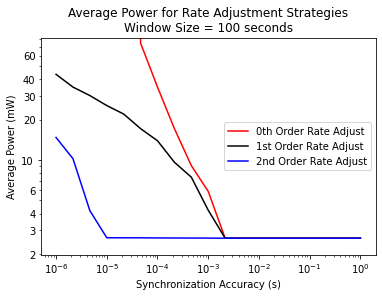

In [23]:
# power measurements for acoustic localization
import pickle, math, helpers
W=20
win_ind = 6
sync_tol = 1e-4
sync_tol_ind = 6
bl = []
power = []
capacity = 1000
for ra in [0,1,2]:
    filename = f'./data_store/datamap_fixedTemperature_RA={ra}.pickle'
    data = None
    with open(filename, 'rb') as infile:
        data = pickle.load(infile)

        sync_tol = data['sync_tol']
        # print(sync_tol)
        W = data['window_size'][win_ind]
        # print(window_sizes[win_ind])
        bbl = data['battery_life'][:,win_ind]
        print(bbl[sync_tol_ind])
        power.append(capacity * 3.3*3.6 / (bbl*86400))
        print(power[ra][sync_tol_ind])

print(W)
if W != math.inf:
    if int(W)==21: W=20
    if int(W)==464: W=500
helpers.plot_power_usage_curves(sync_tol, power, window_size=W)

[array([  0.83970658,   1.79653418,   3.81354335,   7.96291536,
        16.09044407,  30.57337635,  52.51132845,  78.73556159,
       102.3513236 ,  92.59043312, 104.79091793]), array([  0.83970658,   1.79653418,   3.81354335,   7.96291536,
        16.09044407,  30.57337635,  52.51132845,  78.73556159,
       102.3513236 , 104.01181498, 136.4       ]), array([  0.83969465,   1.79650899,   3.81349066,   7.96269729,
        16.08983801,  30.57168405,  52.5062352 ,  78.79599753,
       102.33347306, 118.48639185, 138.42783663])]
[Text(0, 0, '')]


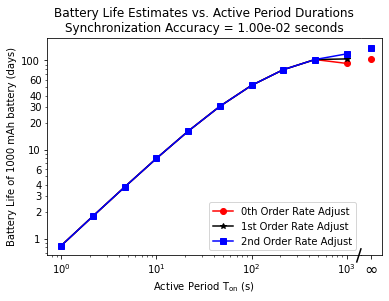

In [5]:
import pickle, helpers
rate_adjusts = [0,1,2]
bl = []
sync_tol_ind = 12
window_size_ind = 6
window_size = None

for ra in rate_adjusts:
    filename = f'./data_store/datamap_fixedTemperature_RA={ra}.pickle'
    data = None
    with open(filename, 'rb') as infile:
        data = pickle.load(infile)
        bl.append(data['battery_life'][sync_tol_ind,:])

        sync_tol = data['sync_tol'][sync_tol_ind]
        window_size = data['window_size']

# print(bl_100)
print(bl)
helpers.plot_battery_usage_curves_duty(window_size, bl, sync_tol)

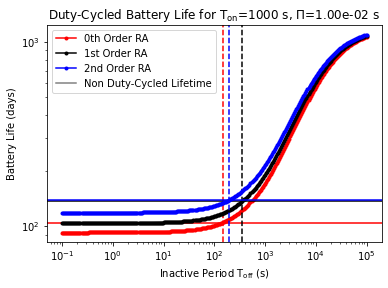

In [7]:
#Find holdover points

import pickle, helpers
import numpy as np
rate_adjusts = [0,1,2]

num_windows = np.zeros((3, 19, 11))
battery_life = np.zeros(num_windows.shape)
energy_per_window = np.zeros(num_windows.shape)
sync_tol = None
window_sizes = None

#(ra, sync_tol_index, window_size_index, color, marker)
comparison_points = [(0, 12, 9, 'r', '.'), (1, 12, 9, 'k', '.'), (2, 12, 9, 'b', '.')]
# comparison_points = [(1, 6, 6, 'r', '.')]

for ra in rate_adjusts:
    filename = f'./data_store/datamap_fixedTemperature_RA={ra}.pickle'
    bl_data = None
    with open(filename, 'rb') as infile:
        data = pickle.load(infile)

        sync_tol = data['sync_tol']
        window_sizes = data['window_size']

        battery_life[ra,:,:] = data['battery_life']
        nm = battery_life[ra,:,:] * 86400/ window_sizes
        num_windows[ra,:,:] = nm
        energy_per_window[ra,:,:] = data['energy_per_window']



# print(bl_100)
# helpers.plot_num_windows_curves(window_sizes, num_windows, sync_tol=sync_tol)

helpers.find_and_plot_holdover_points(battery_life, num_windows, energy_per_window, window_sizes, sync_tol, comparison_points=comparison_points, sleep_current=35e-6)